# 0.0. Imports

In [1]:

import numpy      as np
import pandas     as pd
import boruta     as bt
import scikitplot as skplt
import inflection
#import psycopg2  as pg
import pickle

import seaborn                as sns
from matplotlib import pyplot as plt

from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn import linear_model    as lm
from sklearn import preprocessing   as pp
from sklearn import model_selection as ms
from sklearn.metrics import top_k_accuracy_score

## 0.1. Helper Function

In [2]:
def precision_at_k(data, k=10):
    """
    Calcula a precisão no k-ésimo item recomendado.
    
    Argumentos:
    - data: um DataFrame contendo as colunas "response" (1 para resposta relevante e 0 caso contrário) e 
      "ranking" (posição do item recomendado)
    - k: o valor de k para o qual se deseja calcular a precisão. O valor padrão é 10.
    
    Retorna:
    - A precisão no k-ésimo item recomendado e o DataFrame "data" atualizado com a coluna "precision_at_k"
    """
    # Reseta o índice do DataFrame "data"
    data = data.reset_index(drop=True)
    
    # Cria a coluna "ranking" com base no índice do DataFrame
    data['ranking'] = data.index + 1
    
    # Calcula a precisão acumulada
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    # Retorna a precisão no k-ésimo item recomendado e o DataFrame "data" atualizado
    return (data.loc[k, 'precision_at_k'], data)


def recall_at_k(data, k=15):
    """
    Calcula o recall no k-ésimo item recomendado.
    
    Argumentos:
    - data: um DataFrame contendo as colunas "response" (1 para resposta relevante e 0 caso contrário) e 
      "ranking" (posição do item recomendado)
    - k: o valor de k para o qual se deseja calcular o recall. O valor padrão é 15.
    
    Retorna:
    - O recall no k-ésimo item recomendado e o DataFrame "data" atualizado com a coluna "recall_at_k"
    """
    # Reseta o índice do DataFrame "data"
    data = data.reset_index(drop=True)
    
    # Cria a coluna "ranking" com base no índice do DataFrame
    data['ranking'] = data.index + 1
    
    # Calcula o recall acumulado
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    # Retorna o recall no k-ésimo item recomendado e o DataFrame "data" atualizado
    return (data.loc[k, 'recall_at_k'], data)


# 0.2. Load dataset

In [3]:
# # Define as variáveis de conexão do PostgreSQL
# HOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# PORT = '5432'
# DATABASE = 'comunidadedsdb'
# USER = 'member'
# PASSWORD = 'cdspa'

# # Conecta-se ao PostgreSQL usando a biblioteca psycopg2
# conn = pg.connect(host=HOST, database=DATABASE, port=PORT, user=USER, password=PASSWORD)

# # Define a query que seleciona todos os registros de três tabelas em um único resultado
# query = """
#     SELECT *
#     FROM pa004.users u INNER JOIN pa004.vehicle v ON (u.id = v.id)
#                        INNER JOIN pa004.insurance i ON (u.id = i.id)
# """

# # Executa a query e armazena o resultado em um DataFrame do pandas
# df1 = pd.read_sql(query, conn)



In [4]:
df_raw = pd.read_csv('../src/data/train.csv')

In [5]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Description

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [8]:
# Definir as colunas antigas
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

# Definir a função lambda para converter em snake_case
snakecase = lambda x: inflection.underscore(x)

# Aplicar a função lambda a cada coluna na lista cols_old e obter uma nova lista de colunas com snake_case
cols_new = list(map(snakecase, cols_old))

# Substituir os nomes das colunas do DataFrame por suas versões snake_case
df1.columns = cols_new


## 1.2. Data Dimensions

In [9]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Change Types

In [11]:

#df1['age'] = df1['age'].astype(float)
#df1['response'] = df1['response'].astype(float)

#df1.dtypes

## 1.5. Check NA

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.6. Descriptive Statistics

In [13]:
# Separando atributos numéricos e categóricos do dataframe

# Seleciona apenas colunas do tipo numérico
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# Seleciona todas as colunas que não são numéricas ou datas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])



### 1.6.1. Numerical Attributes

In [14]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatena todos os dataframes criados anteriormente
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# Renomeia as colunas
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

metrics



,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.6.2. Categorical Attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0. Feature Engineering


In [16]:
df2 = df1.copy()

In [17]:

# Mapeando a coluna 'vehicle_damage' de 'Yes' e 'No' para valores binários de 1 e 0.
df2['vehicle_damage'] = df2['vehicle_damage'].map({'Yes': 1, 'No': 0})

# Transformando os valores categóricos em nomes mais descritivos
df2['vehicle_age'] = df2['vehicle_age'].map({'> 2 Years': 'over_2_years', '1-2 Year': 'between_1_2_year', '< 1 Year': 'below_1_year'})

# 3.0. Data Filtering

In [18]:
df3 = df2.copy()

# 4.0. Data Analysis

In [19]:
df4 = df3.copy()

#### Hipóteses

1. Os clientes mais jovens têm menos probabilidade de se interessar por um seguro de carro.
2. Clientes que pagam um prêmio de seguro mais alto têm mais probabilidade de adquirir um seguro de veículo.
3. Clientes que possuem licença para dirigir têm mais probabilidade de adquirir um seguro.
4. A região em que o cliente reside tem influência na probabilidade de adquirir um seguro de veículo.
5. Clientes que não possuem seguros têm maior probabilidade de adquirir um seguro de veículo.
6. Veículos mais novos têm mais probabilidade de ter um seguro de veículo.
7. Clientes que possuem veículos com danos anteriores têm menos probabilidade de adquirir um seguro de veículo.
8. Os clientes que foram abordados por um número menor de canais de vendas têm maior probabilidade de se interessar por um seguro de carro.
9. Clientes há mais tempo com seguro saúde têm maior probabilidade de se interessar por um seguro de carro.
10. Mulheres são mais propensas a adquirir um seguro de veículo do que homens.
11. Os clientes que vivem em áreas com maiores taxas de roubo de carros têm maior probabilidade de se interessar por um seguro de carro.
12. Clientes que possuem veículos de maior valor têm mais probabilidade de ter um seguro de veículo.

## 4.1. Univariate Analysis

### 4.1.1. Age

##### H1. Os clientes mais jovens têm menos probabilidade de se interessar por um seguro de carro.

##### VERDADEIRA, o maio índice de pessoas que não querem o seguro de carro é entre 20 e 30 anos.

<AxesSubplot: xlabel='response', ylabel='age'>

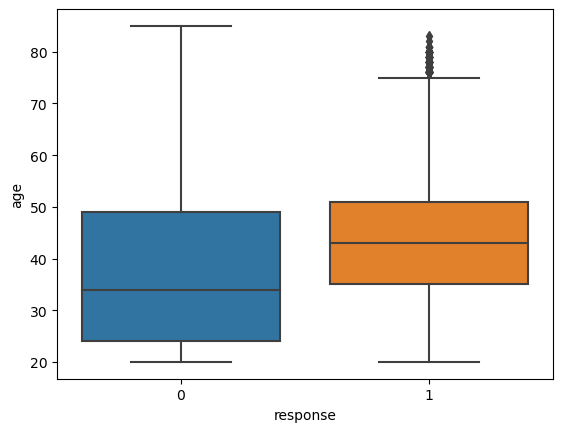

In [20]:
sns.boxplot(x='response', y='age', data=df4)

<AxesSubplot: xlabel='age'>

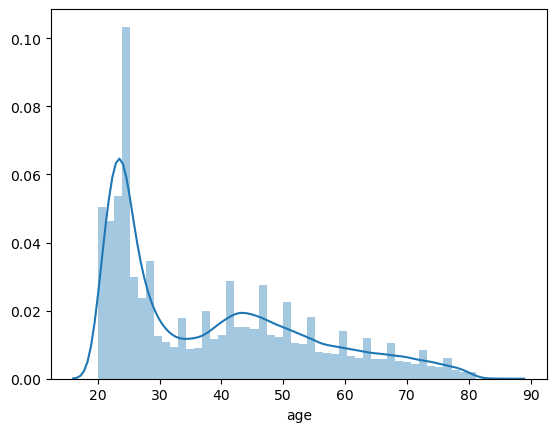

In [21]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.distplot(aux00)

<AxesSubplot: xlabel='age'>

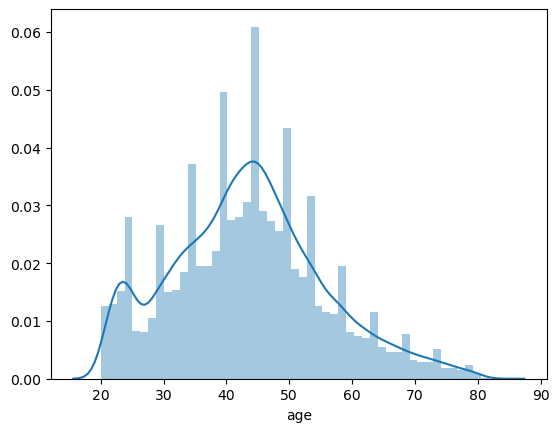

In [22]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.distplot(aux00)

In [23]:
# OBS: A classe com pessoas interessadas (1) contém uma quantidade muito menor, aproximadamente 1750, 
# enquanto a classe sem interesse (0) possui 25000. Ou seja, as classes estão desbalanceadas

### 4.1.2. Anual Premium

#### H2. Clientes que pagam um prêmio de seguro mais alto têm mais probabilidade de adquirir um seguro de veículo.

##### FALSA, os dados estão muito parecidos 

<AxesSubplot: xlabel='response', ylabel='annual_premium'>

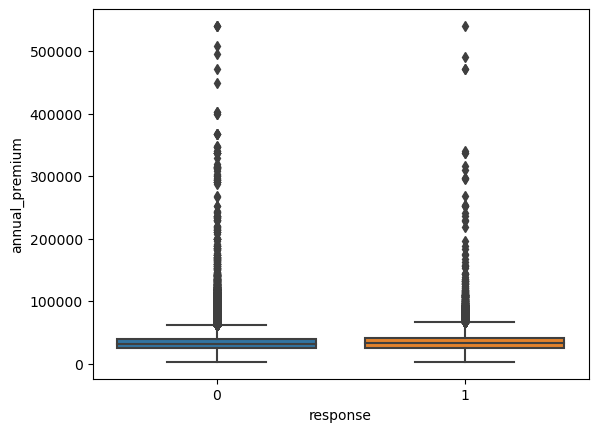

In [24]:
sns.boxplot(x='response', y='annual_premium', data=df4)

In [25]:
df4 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 100000)]

<AxesSubplot: xlabel='annual_premium'>

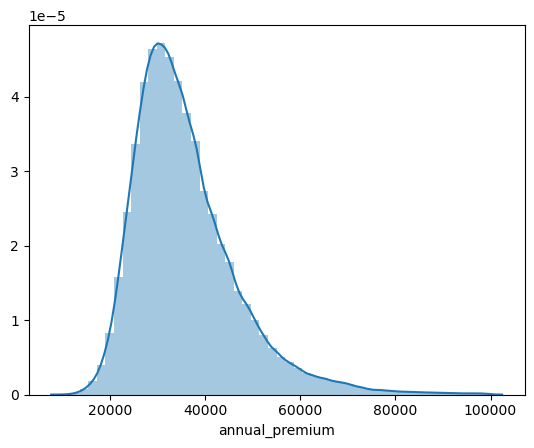

In [26]:
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.distplot(aux00)

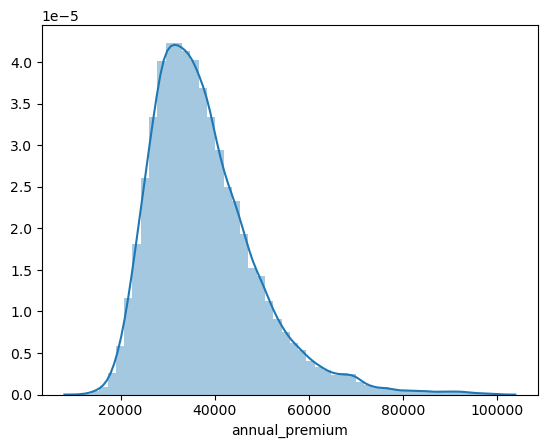

In [27]:
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.distplot(aux00);

In [28]:
# OBS: Por serem muito parecidas, possivelmente não irão contribuir para a classificação dos dados
# Muitos Outliers

### 4.1.3. Driving License

#### H3. Clientes que possuem licença para dirigir têm mais probabilidade de adquirir um seguro

##### VERDADEIRA

<AxesSubplot: xlabel='response', ylabel='driving_license'>

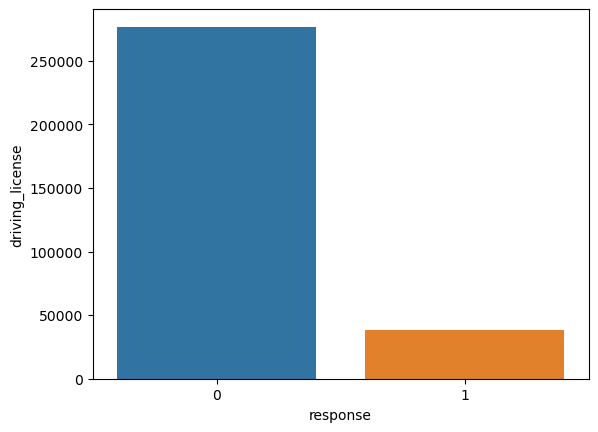

In [29]:
aux01 = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='driving_license', data=aux01)

In [30]:
pd.crosstab(df4['driving_license'], df4['response']).apply(lambda x: x / x.sum(), axis=1)


response,0,1
driving_license,,
0,0.950437,0.049563
1,0.879125,0.120875


### 4.1.4. Region Code

#### H4. A região em que o cliente reside tem influência na probabilidade de adquirir um seguro de veículo

##### FALSA, a região não é determinante para a maioria dos casos

<AxesSubplot: xlabel='region_code', ylabel='id'>

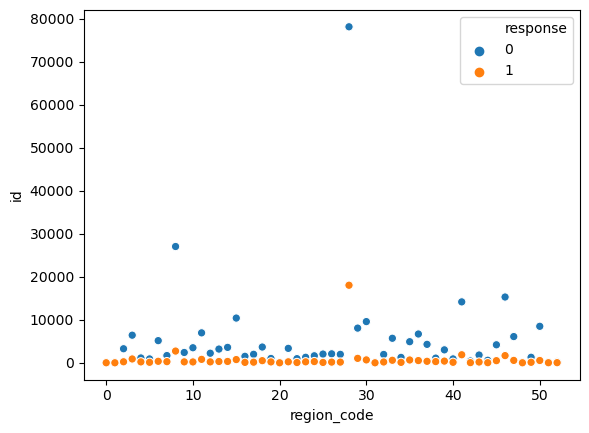

In [31]:
aux02 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux02)

### 4.1.5. Previously Insured

#### H5. Clientes que não possuem seguros têm maior probabilidade de adquirir um seguro de veículo

##### VERDADEIRA

<AxesSubplot: xlabel='previously_insured', ylabel='id'>

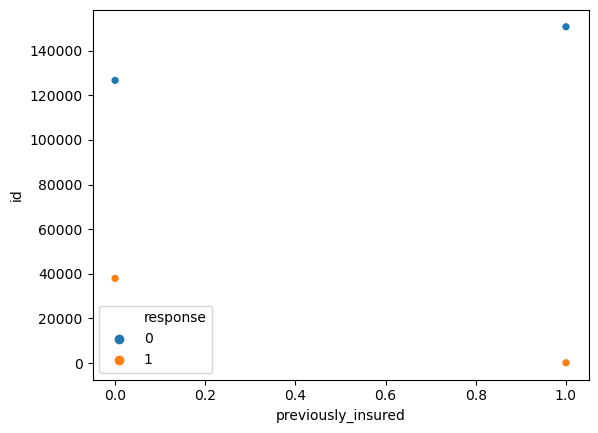

In [32]:
aux0 = df4[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='previously_insured', y='id', hue='response', data=aux0 )

In [33]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis=1)


response,0,1
previously_insured,,
0,0.769438,0.230562
1,0.999191,0.000809


In [34]:
# OBS: VAZAMENTO DE DADOS!   essa variavel é um vazamento de dados, pq para o modelo ficará 
# obvio que as pessoas que já tem um seguro de carro não estão interessadas,
# tendo em vista que 99.9% afirmaram isto

### 4.1.6. Vehicle Age

#### H6. Veículos mais novos têm mais probabilidade de ter um seguro de veículo

##### VERDADEIRA

In [35]:
df4[['id', 'vehicle_age', 'response']].groupby(['vehicle_age', 'response']).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,137861
1,below_1_year,1,5994
2,between_1_2_year,0,130381
3,between_1_2_year,1,28017
4,over_2_years,0,9126
5,over_2_years,1,4070


In [36]:
# OBS: para as pessoas com carros acima de dois anos a porcentagem é muito parecida.
# Já para com menos de 1 ano e entre 1 e 2 anos, a resposta é bem diferente, e isso pode ajudar o modelo a classificar.
# O problema é que estas variaves estão juntas

### 4.1.7. Vehicle Damage

#### H7. Clientes que possuem veículos com danos anteriores têm menos probabilidade de adquirir um seguro de veículo

##### FALSA, clientes que possuem veículos com danos anteriores têm maior probabilidade de adquirir um seguro

<AxesSubplot: xlabel='response', ylabel='vehicle_damage'>

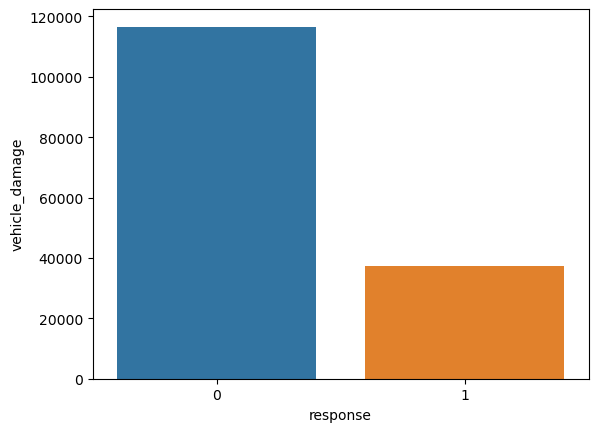

In [37]:
aux04 = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='vehicle_damage', data=aux04)

In [38]:
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.995850,0.004150
1,0.757097,0.242903


### 4.1.8. Policy Sales Channel - Stacked Percentage Bar

#### H8. Os clientes que foram abordados por um número menor de canais de vendas têm maior probabilidade de se interessar por um seguro de carro

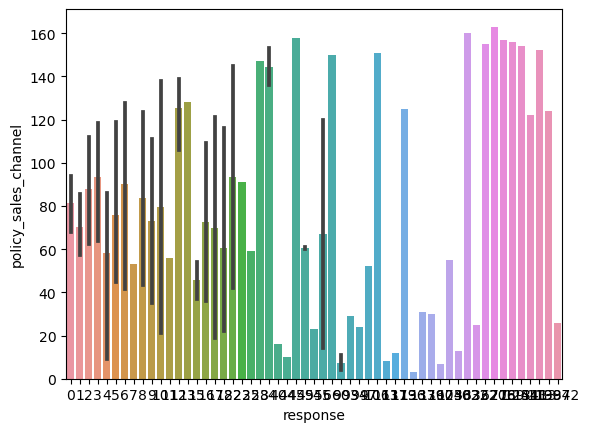

In [39]:
aux05 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux05 );


<AxesSubplot: xlabel='policy_sales_channel'>

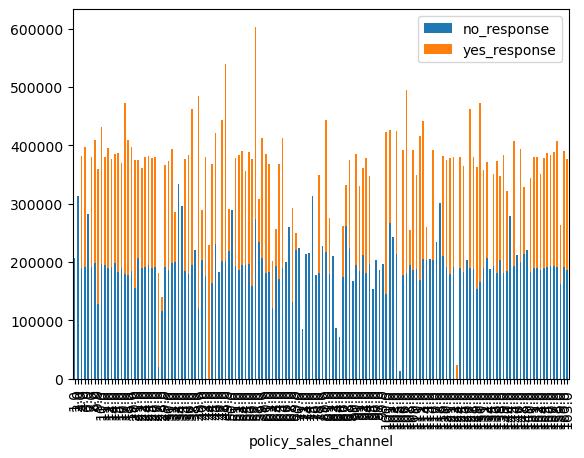

In [40]:
df = pd.pivot_table(index='policy_sales_channel', columns='response', values='id', data=df4).reset_index()
df.columns = ['policy_sales_channel', 'no_response', 'yes_response']

df.plot(x='policy_sales_channel', kind='bar', stacked=True)

In [41]:
aux06 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
aux07 = df4[['id', 'policy_sales_channel']].groupby('policy_sales_channel').size().reset_index().rename(columns={0: 'total_responses'})

aux = pd.merge(aux06, aux07, how='inner', on='policy_sales_channel')
aux

,policy_sales_channel,response,total_responses
0,1.0,0,10
1,2.0,0,1
2,3.0,136,434
3,4.0,90,442
4,6.0,0,2
...,...,...,...
143,157.0,706,2353
144,158.0,45,148
145,159.0,1,21
146,160.0,303,16225


### 4.1.9. Vintage

#### H9. Clientes há mais tempo com seguro saúde têm maior probabilidade de se interessar por um seguro de carro

##### FALSA, pelos dados não é possivel comprovar isso

<AxesSubplot: xlabel='vintage'>

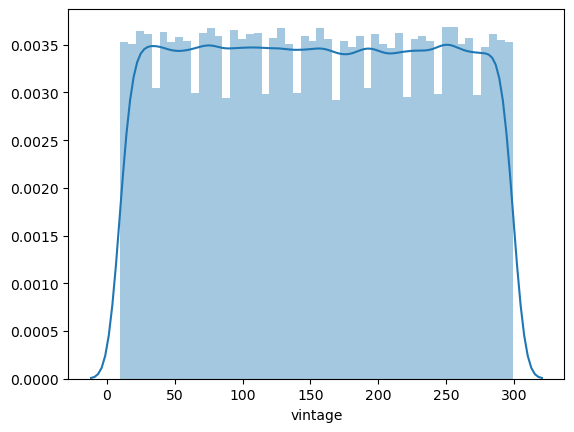

In [42]:
aux08 = df4.loc[df4['response'] == 0, 'vintage']
sns.distplot(aux08)

<AxesSubplot: xlabel='vintage'>

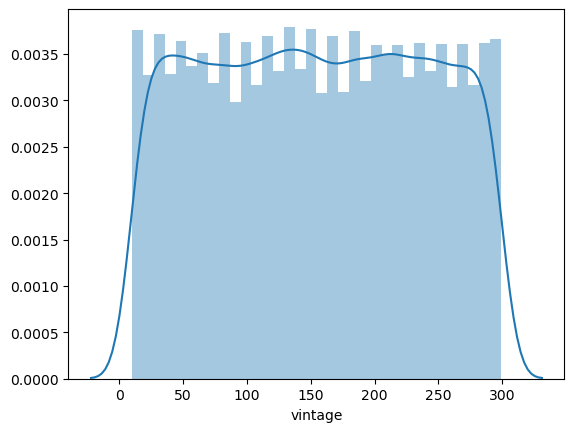

In [43]:
aux09 = df4.loc[df4['response'] == 1, 'vintage']
sns.distplot(aux09)

<AxesSubplot: xlabel='vintage'>

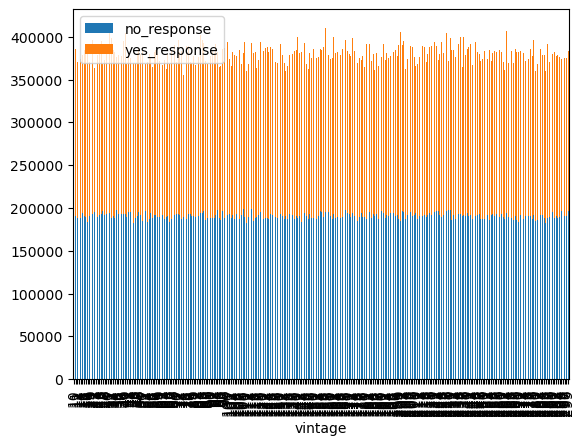

In [44]:
df = pd.pivot_table(index='vintage', columns='response', values='id', data=df4).reset_index()
df.columns = ['vintage', 'no_response', 'yes_response']

df.plot(x='vintage', kind='bar', stacked=True)

### 4.1.10. Gender


#### H10. Mulheres são mais propensas a adquirir um seguro de veículo do que homens

##### FALSA, homens são mais propensos a adquirir um seguro

In [45]:
df4[['id', 'gender', 'response']].groupby(['gender', 'response']).count().reset_index()

,gender,response,id
0,Female,0,131981
1,Female,1,14734
2,Male,0,145387
3,Male,1,23347


# 5.0. Data Preparation

In [46]:
# Separação dos dados em variáveis preditoras (X) e variável alvo (y)
X = df4.drop('response', axis=1)
y = df4['response'].copy()

# Divisão dos dados em conjunto de treino e conjunto de validação
x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

# Criação do DataFrame df5, que é a concatenação das variáveis preditoras e alvo do conjunto de treino
df5 = pd.concat([x_train, y_train], axis=1)


## 5.1. Standardization 

In [47]:
# Instanciando o StandardScaler
ss = pp.StandardScaler()

# Aplicando o StandardScaler na coluna 'annual_premium' e salvando o modelo treinado
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb' ))


## 5.2. Rescaling

In [48]:
# Inicializando dois objetos MinMaxScaler para normalização das colunas 'age' e 'vintage'.
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Aplicando o MinMaxScaler na coluna 'age' e salvando o scaler em um arquivo .pkl para uso futuro.
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))

# Aplicando o MinMaxScaler na coluna 'vintage' e salvando o scaler em um arquivo .pkl para uso futuro.
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb' ))

## 5.3. Transformation

### 5.3.1. Encoding

In [49]:
# gender - One Hot Encoding / Target Encoding
# Target Encoding utilizando a média da coluna 'response' agrupada por 'gender'
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
# Salva o objeto target_encode_gender no formato pickle para ser utilizado posteriormente
pickle.dump(target_encode_gender, open('../src/features/target_encode_gender_scaler.pkl', 'wb' ))

# region_code - Target Encoding / Frequency Encoding
# Target Encoding utilizando a média da coluna 'response' agrupada por 'region_code'
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
# Salva o objeto target_encode_region_code no formato pickle para ser utilizado posteriormente
pickle.dump( target_encode_region_code, open( '../src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
# One Hot Encoding da coluna 'vehicle_age'
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
# Frequency Encoding da coluna 'policy_sales_channel'
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
# Salva o objeto fe_policy_sales_channel no formato pickle para ser utilizado posteriormente
pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))


C:\Users\raquel\AppData\Local\Temp\ipykernel_20088\4078570828.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)


## 5.4. Validation Preparation

In [50]:
# gender: aplica a codificação alvo (target encoding) na coluna 'gender'
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map(target_encode_gender)

# age: aplica a transformação MinMaxScaler na coluna 'age'
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code: aplica a codificação alvo (target encoding) na coluna 'region_code'
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age: cria variáveis dummy para a coluna 'vehicle_age'
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium: aplica a transformação StandardScaler na coluna 'annual_premium'
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel: aplica a Frequency Encoding na coluna 'policy_sales_channel'
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage: aplica a transformação MinMaxScaler na coluna 'vintage'
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)


C:\Users\raquel\AppData\Local\Temp\ipykernel_20088\1416397398.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map(target_encode_gender)


In [51]:

x_validation.isna().sum()

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0. Feature Selection    

## 6.1. Boruta Algorithm

In [52]:
# Define os dados de treinamento
x_train_n = df5.drop(['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel()

# Define o modelo ExtraTreesClassifier
et = en.ExtraTreesClassifier(n_jobs=-1)

# Define o BorutaPy, que seleciona as features mais relevantes do modelo
boruta = bt.BorutaPy(et, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	10


BorutaP

In [53]:
# Cria uma lista de booleanos, com True para as features selecionadas pelo Boruta
cols_selected = boruta.support_.tolist()

# Seleciona apenas as colunas correspondentes às melhores features
# a partir do dataset original
x_train_fs = df5.drop(['id', 'response'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# features não selecionadas pelo Boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))


## 6.2. Feature Importance

In [54]:
# Definindo o modelo de classificação com o algoritmo ExtraTreesClassifier
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# Preparando os dados de treino: separando as colunas 'id' e 'response'
# os dados de entrada são todos os atributos do dataframe, exceto 'id' e 'response'
x_train_n = df5.drop(['id', 'response'], axis=1)

# Preparando os dados de treino: definindo os dados de saída (variável alvo)
# os dados de saída são obtidos da coluna 'response' do dataframe original
y_train_n = y_train.values

# Treinando o modelo com os dados de treino
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                annual_premium    0.274911
0                       vintage    0.248189
0                           age    0.157892
0                   region_code    0.101589
0                vehicle_damage    0.068850
0            previously_insured    0.060901
0          policy_sales_channel    0.056801
0      vehicle_age_below_1_year    0.015671
0  vehicle_age_between_1_2_year    0.006860
0                        gender    0.004680
0      vehicle_age_over_2_years    0.003134
0               driving_license    0.000522


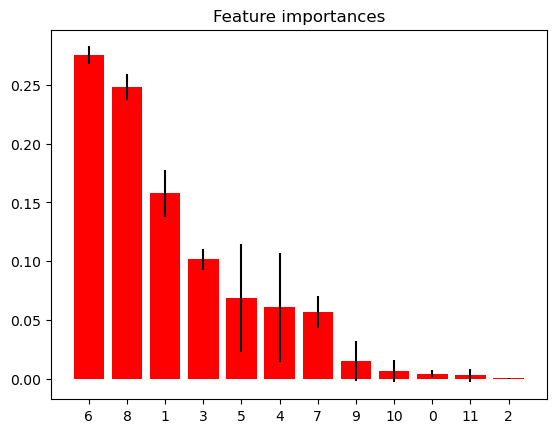

In [55]:
# Importância de cada feature
importances = forest.feature_importances_ 

# Desvio padrão das importâncias para cada feature
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0) 

# Ordena as importâncias em ordem decrescente
indices = np.argsort(importances)[::-1] 

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center") # plot das importâncias
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


# 7.0. Machine Learning Modelling

In [56]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

In [57]:
# Selecionando as colunas de acordo com a importância
x_train = df5[cols_selected]

x_val = x_validation[cols_selected]
y_val = y_validation

## 7.1. KNN Classifier

In [58]:
# Definição do modelo KNN (k-nearest neighbors)
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# Treinamento do modelo com os dados de treino
knn_model.fit(x_train, y_train)

# Realização da predição com o modelo treinado nos dados de validação
yhat_knn = knn_model.predict_proba(x_val)


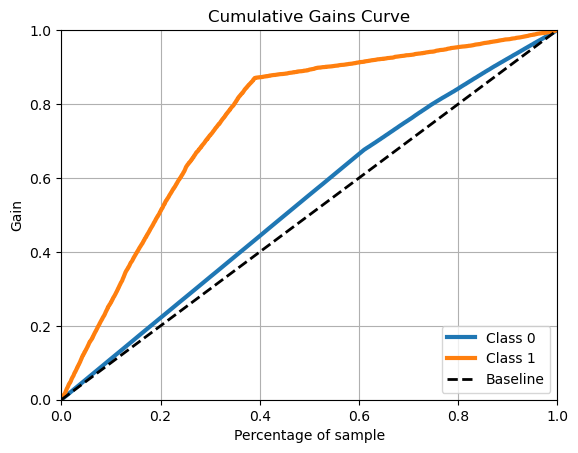

In [59]:
# Accumulative Gain
# Mostra a proporção acumulada de amostras positivas à medida que a amostra é classificada em ordem decrescente de probabilidade
# Permite avaliar a eficácia do modelo em encontrar a maior proporção possível de amostras positivas no topo da lista classificada
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

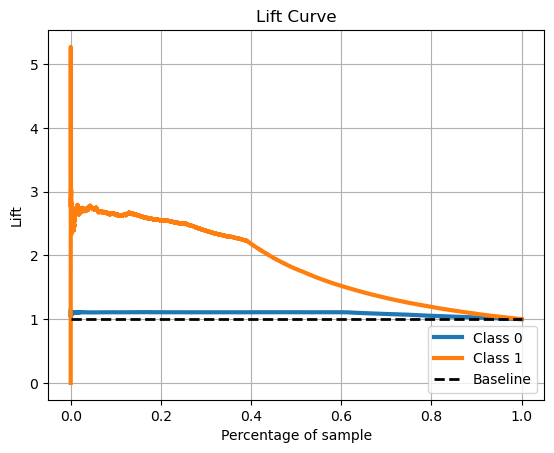

In [60]:
# Lift Curve
# Mostra a proporção de amostras positivas em relação à proporção total de amostras classificadas. 
# Esse gráfico é útil para comparar a performance do modelo com um modelo aleatório.
skplt.metrics.plot_lift_curve(y_val, yhat_knn);

## 7.2. Logistic Regression

In [61]:
# Definição do modelo Logistic Regression
lr_model = lm.LogisticRegression(random_state=42) 

# Treinamento do modelo
lr_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_lr = lr_model.predict_proba(x_val)


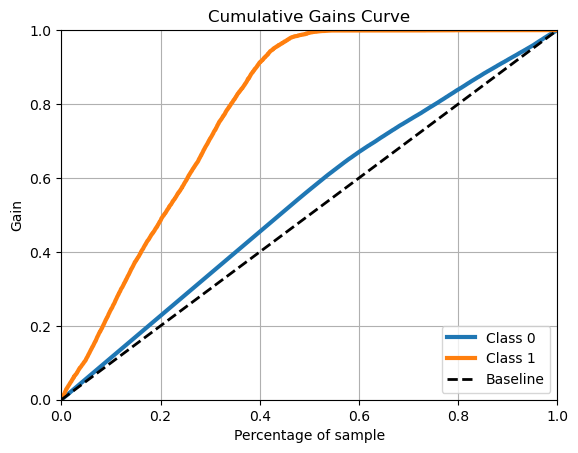

In [62]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

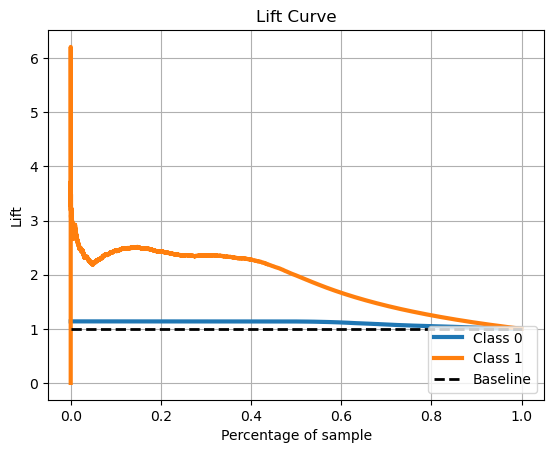

In [63]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr);

## 7.3. Extra Trees Classifier

In [64]:
# Definição do modelo Extra Trees Classifier
et = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# Treinamento do modelo
et.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_et = et.predict_proba(x_val)


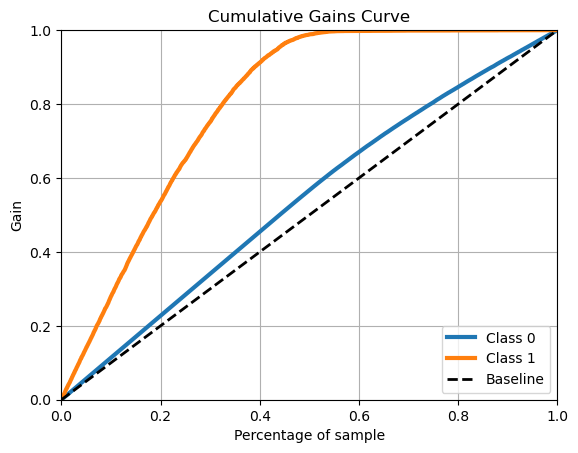

In [65]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

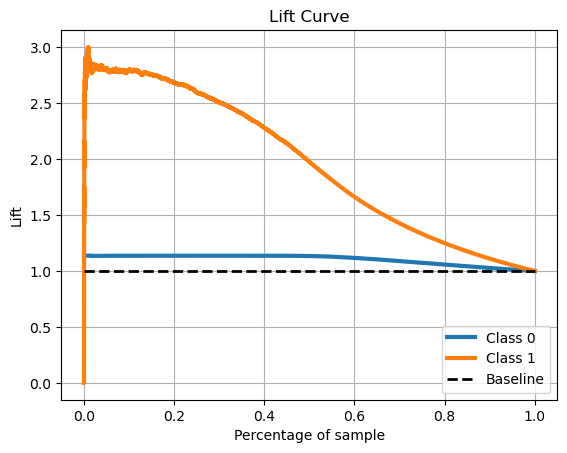

In [66]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_et);

## 7.4. Random Forest

In [67]:
# Definição do modelo Random Forest
rf = en.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# Treinamento do modelo
rf.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_rf = et.predict_proba(x_val)

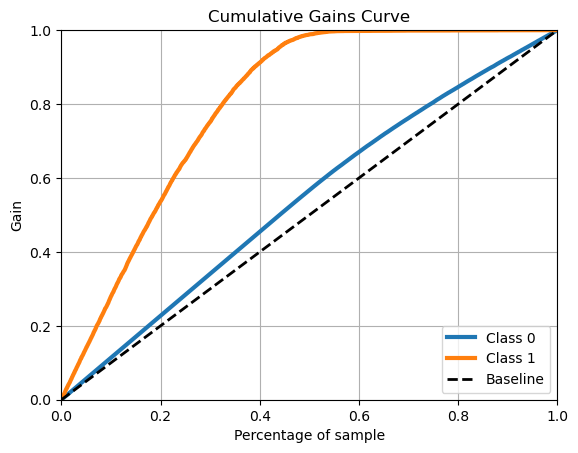

In [68]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

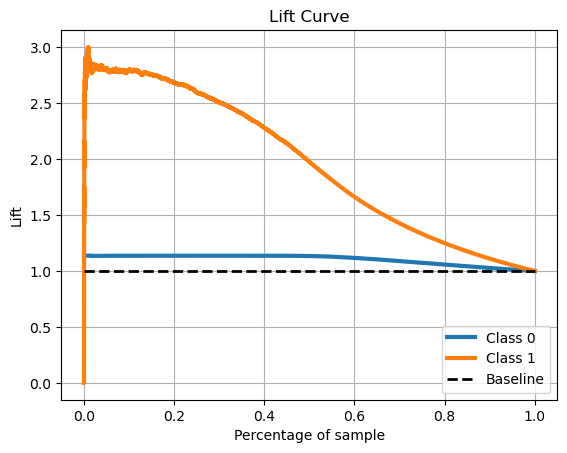

In [69]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_rf);

# 8.0. Performance Metrics

In [70]:
# funções em 0.1. Helper Function

In [71]:
# Copia o dataframe da amostra de validação
df8 = x_validation.copy()

# Cria uma nova coluna no dataframe para a variável resposta (y_validation)
df8['response'] = y_validation.copy()

# Calcula o score de propensão utilizando o modelo treinado (yhat_lr)
df8['score'] = yhat_et[:, 1].tolist()

# Ordena os clientes pela pontuação de propensão, em ordem decrescente
df8 = df8.sort_values('score', ascending=False)

# Calcula a precisão para os 20 primeiros clientes
precision_at_20, data = precision_at_k(df8, k=20)

# Calcula o recall para os 15 primeiros clientes
recall_at_15, data = recall_at_k(df8, k=15)

In [72]:
# Exemplo de uso da função top_k_accuracy_score
# Define os valores verdadeiros e as probabilidades preditas para cada classe
y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],  # 0 está no top 2
                    [0.3, 0.4, 0.2],  # 1 está no top 2
                    [0.2, 0.4, 0.3],  # 2 está no top 2
                    [0.7, 0.2, 0.1]]) # 2 não está no top 2

# Calcula a acurácia nos top k valores, neste caso top 2
top_k_accuracy_score(y_true, y_score, k=2)


0.75

In [73]:
y_true = np.array([1, 0, 1, 1, 0, 1, 0, 0])
y_score = np.array([])

## 8.1. Cummulative Curve Manually

<AxesSubplot: xlabel='base_cum_perc', ylabel='baseline'>

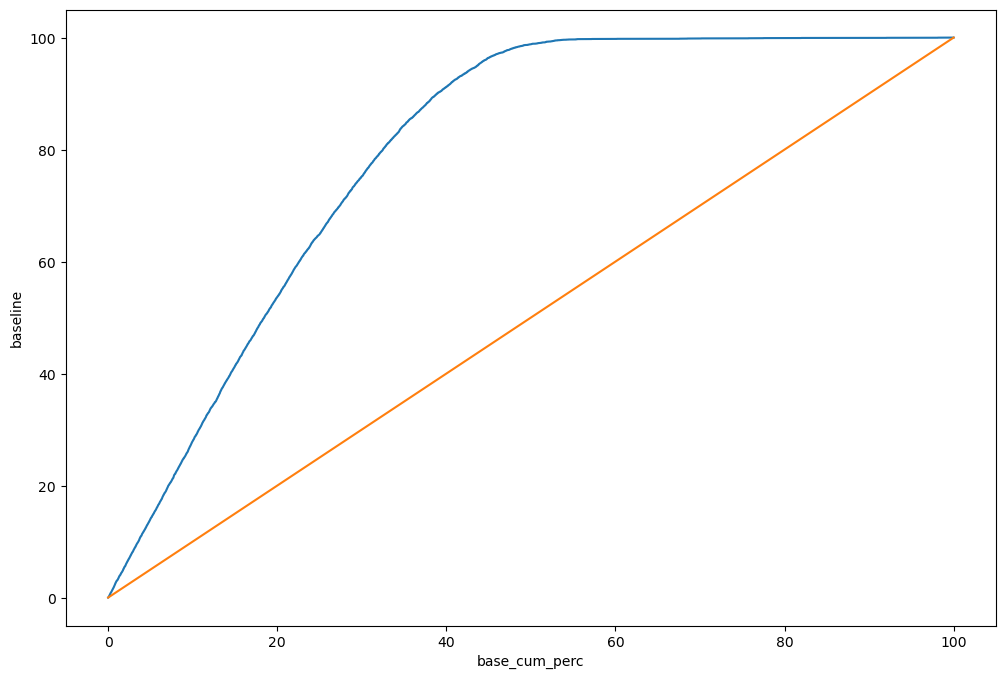

In [74]:
# Cria um dataframe com as colunas de 'predição' e 'real'
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# Ordena por ordem decrescente de acordo com a predição
results = results.sort_values('prediction', ascending=False)

# Calcula a porcentagem acumulada de clientes que realmente compraram (interesse - Propensity Score)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Calcula a porcentagem acumulada de clientes (base)
results['base'] = range(1, len(results ) + 1)
results['base_cum_perc'] = 100*results['base']/len(results)

# Cria uma coluna de referência (baseline)
results['baseline'] = results['base_cum_perc']

# Plota o gráfico com as linhas de porcentagem acumulada de interesse e baseline
plt.figure(figsize=(12,8))
sns.lineplot(x='base_cum_perc', y='real_cum_perc', data=results)
sns.lineplot(x='base_cum_perc', y='baseline', data=results)


## 8.2. Lift Curve Manually

<AxesSubplot: xlabel='base_cum_perc', ylabel='lift'>

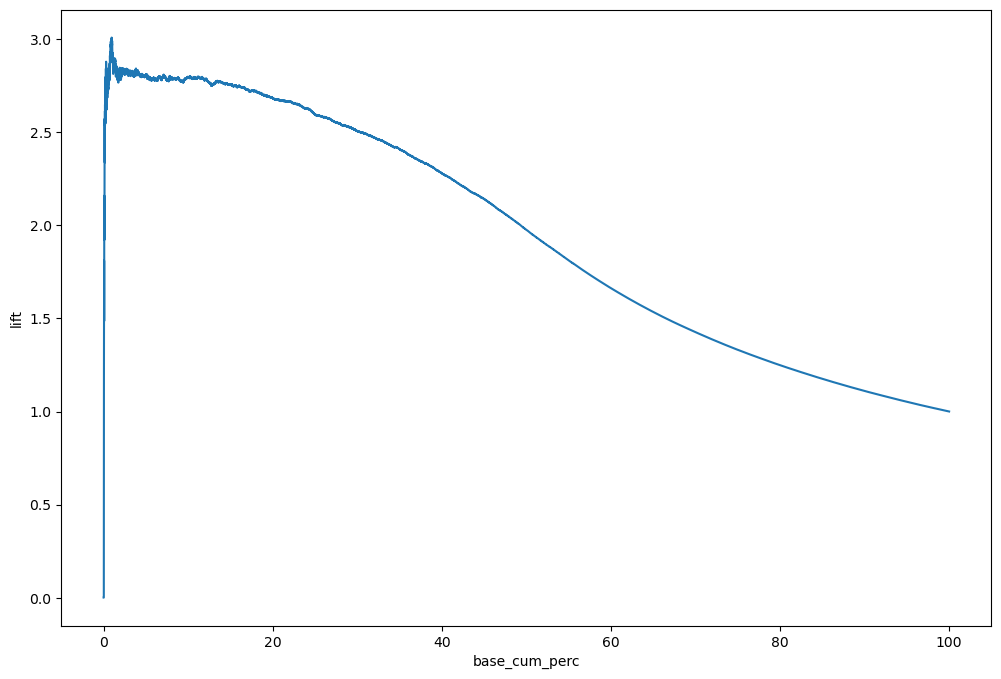

In [75]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordenando por previsão
results = results.sort_values('prediction', ascending=False)

# porcentagem de interesse (score de propensão)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum'] / results['real'].sum()

# porcentagem da base (clientes)
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100*results['base'] / len(results)

# modelo baseline
results['baseline'] = results['base_cum_perc']

# cálculo do lift
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure(figsize=(12,8))
sns.lineplot(x='base_cum_perc', y='lift', data=results)


## 8.3. ROI Curve Manually

In [76]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values('prediction', ascending=False)

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum'] / results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100*results['base'] / len(results)

# Baseline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# ROI Curve
# plt.figure(figsize=(12,8))
# plt.plot(results['base_cum_perc'], results['lift'])
# plt.plot(results['base_cum_perc'], results['baseline'])
# plt.xlabel('Percentage of Clients Targeted')
# plt.ylabel('Lift')
# plt.title('ROI Curve')
# plt.legend(['Model', 'Baseline'])
# plt.show()


In [77]:
# Compute bucket based on prediction values
# O código abaixo cria uma nova coluna chamada "bucket" na tabela "results", 
# que classifica os clientes em diferentes intervalos de propensão de acordo com 
# suas pontuações de predição.
results['bucket'] = results['prediction'].apply(
    lambda x: 0.9 if x >= 0.90 else 
              0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
              0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
              0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
              0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
              0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
              0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
              0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
              0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 
)

# agrupa os clientes por "bucket" e computa a contagem de clientes em cada intervalo de propensão, bem como a pontuação mínima de predição em cada intervalo
df = results[['prediction','bucket']].groupby('bucket').agg({'min', 'count'}).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Calcula a receita bruta e o custo em cada intervalo de propensão
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

# Computa o percentual acumulado de clientes e a receita acumulada em cada intervalo de propensão
df['base'] = df['clients'].sort_values(ascending=True).cumsum() / df['clients'].sum()
df['revenue'] = df['gross_revenue'] - df['cost']

# ordena os resultados por índice de intervalo de propensão em ordem decrescente
df = df.sort_values('index', ascending=False)
df


,index,clients,propensity_score,gross_revenue,cost,base,revenue
9,0.90,56,0.9,2016.0,224,0.000888,1792.0
8,0.80,134,0.8,4288.0,536,0.003012,3752.0
7,0.70,349,0.7,9772.0,1396,0.008543,8376.0
6,0.60,820,0.6,19680.0,3280,0.021541,16400.0
5,0.50,1621,0.5,32420.0,6484,0.047234,25936.0
4,0.40,3030,0.4,48480.0,12120,0.095261,36360.0
3,0.30,4644,0.3,55728.0,18576,0.168870,37152.0
2,0.20,6045,0.2,48360.0,24180,0.264685,24180.0
1,0.10,6626,0.1,26504.0,26504,0.369710,0.0
0,0.01,39765,0.0,0.0,159060,1.000000,-159060.0


<AxesSubplot: xlabel='base', ylabel='revenue'>

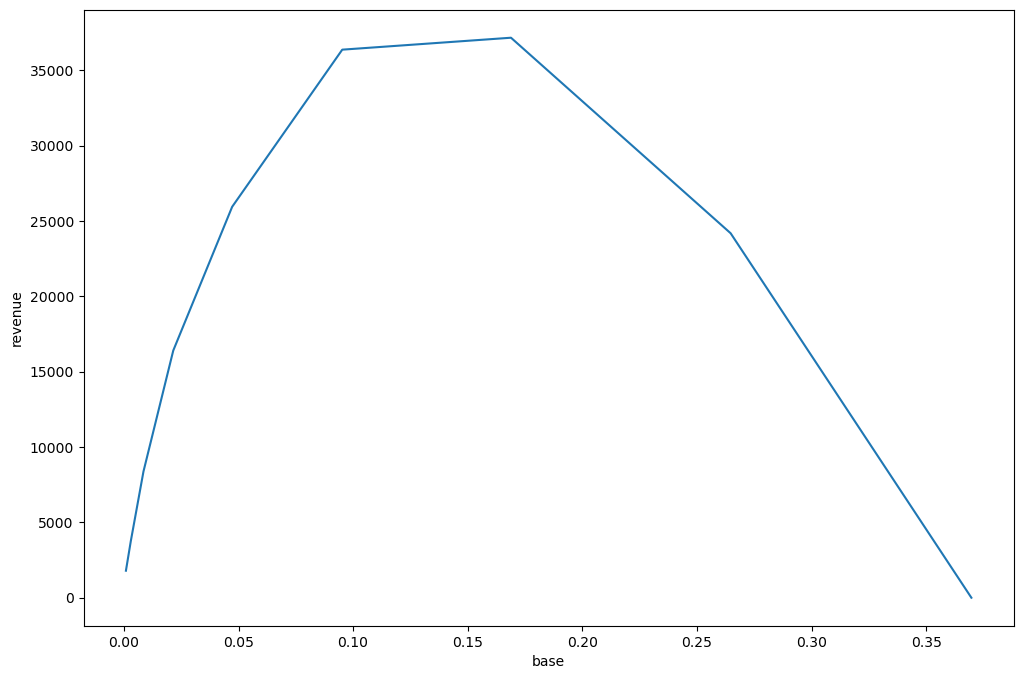

In [78]:
plt.figure(figsize=(12,8))

# Seleciona apenas os dados com propensity_score maior ou igual a 0.1
aux = df[df['propensity_score'] >= 0.1]

# Criação do gráfico de linha
sns.lineplot(x='base', y='revenue', data=aux)


# 9.0. Deploy to Production

In [86]:
# Salva o modelo treinado
#pickle.dump(et, open(r'C:\Users\raquel\Documents\Comunidade DS\repos\06-PA-Health-Insurance-Cross-Sell\health_insurance\health_insurance_ross_sell\src\models\model_extra_tress.pkl', 'wb'))
pickle.dump(lr_model, open(r'C:\Users\raquel\Documents\Comunidade DS\repos\06-PA-Health-Insurance-Cross-Sell\health_insurance\health_insurance_ross_sell\src\models\model_linear_regression.pkl', 'wb'))

## 9.1. Health Insurance Class

In [83]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__(self):
        # Definindo o caminho dos arquivos do projeto
        self.home_path = 'C:\\Users\\raquel\\Documents\\Comunidade DS\\repos\\06-PA-Health-Insurance-Cross-Sell\\health_insurance_ross_sell\\'
        
        # Carregando os objetos scaler gerados no treinamento do modelo
        self.annual_premium_scaler =            pickle.load(open(self.home_path + 'src\\features\\annual_premium_scaler.pkl', 'rb'))
        self.age_scaler =                       pickle.load(open(self.home_path + 'src\\features\\age_scaler.pkl', 'rb')) 
        self.vintage_scaler =                   pickle.load(open(self.home_path + 'src\\features\\vintage_scaler.pkl', 'rb')) 
        self.target_encode_gender_scaler =      pickle.load(open(self.home_path + 'src\\features\\target_encode_gender_scaler.pkl', 'rb'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'src\\features\\target_encode_region_code_scaler.pkl', 'rb'))
        self.fe_policy_sales_channel_scaler =   pickle.load(open(self.home_path + 'src\\features\\fe_policy_sales_channel_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        # 1.1. Renomeando as colunas
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering(self, df2):
        # 2.0. Feature Engineering

        # Criando a coluna 'vehicle_damage_num' para representar os veículos que já foram danificados (1) e os que não foram danificados (0)
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

        # Transformando a coluna 'vehicle_age' em uma coluna categórica para aplicação de técnicas de codificação
        df2['vehicle_age'] =  df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')
        
        return df2
    
    
    def data_preparation(self, df5):
        # Aplicando a transformação de Escalonamento Padrão na coluna 'annual_premium'
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        # Aplicando a transformação de Escalonamento Mínimo e Máximo na coluna 'age'
        df5['age'] = self.age_scaler.transform(df5[['age']].values)

        # Aplicando a transformação de Escalonamento Mínimo e Máximo na coluna 'vintage'
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)

        # Codificando a coluna 'gender' utilizando a técnica de Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map(self.target_encode_gender)

        # Aplica o processo de target encoding na coluna region_code
        df5.loc[:, 'region_code'] = df5['region_code'].map(self.target_encode_region_code)

        # Cria variáveis dummy para a coluna vehicle_age usando a função pd.get_dummies
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

        # Aplica o processo de frequency encoding na coluna policy_sales_channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel)

        # Feature Selection
        # Seleciona as colunas relevantes para o modelo
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

        # Retorna o dataframe com as colunas selecionadas
        return df5[cols_selected]


    def get_prediction(self, model, original_data, test_data):
        # model prediction
        # Usa o modelo treinado para fazer as predições em test_data
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        # Adiciona as predições ao dataframe original
        original_data['prediction'] = pred
        
        # Retorna o dataframe em formato JSON
        return original_data.to_json(orient='records', date_format='iso')



## 9.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# carregando o modelo
path = 'C:\\Users\\raquel\\Documents\\Comunidade DS\\repos\\06-PA-Health-Insurance-Cross-Sell\\health_insurance_ross_sell\\'
model = pickle.load(open(path + 'src/models/model_health_insurance.pkl', 'rb'))

# inicializando a API
app = Flask(__name__)

@app.route('/heathinsurance/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # se houver dados
        if isinstance(test_json, dict): # único exemplo
            test_raw = pd.DataFrame(test_json, index=[0])

        else: # múltiplos exemplos
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instanciando a classe HealthInsurance
        pipeline = HealthInsurance()

        # Limpeza dos dados
        df1 = pipeline.data_cleaning(test_raw)

        # Engenharia de Recursos
        df2 = pipeline.feature_engineering(df1)

        # Preparação dos dados
        df3 = pipeline.data_preparation(df2)

        # Previsão
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)


ModuleNotFoundError: No module named 'healthinsurance'

## 9.3. API Tester

In [ ]:
import requests
import json

In [ ]:
# loading test dataset
df_test = x_validation
df_test['response'] = y_validation

In [ ]:
df_test = df_test.sample(10)

In [ ]:
# convert dataframe to json
data = json.dumps( df_test.to_dict(orient='records'))

In [ ]:
data

'[{"id": 86763, "gender": 0.13856811530848906, "age": 0.19999999999999996, "driving_license": 1, "region_code": 0.088871096877502, "previously_insured": 1, "vehicle_damage": 0, "annual_premium": -0.13589402025478525, "policy_sales_channel": 0.35406888453755, "vintage": 0.11418685121107267, "vehicle_age_below_1_year": 1, "vehicle_age_between_1_2_year": 0, "vehicle_age_over_2_years": 0, "response": 0}, {"id": 253500, "gender": 0.13856811530848906, "age": 0.07692307692307693, "driving_license": 1, "region_code": 0.12034951191207591, "previously_insured": 1, "vehicle_damage": 0, "annual_premium": 0.36152791075810564, "policy_sales_channel": 0.35406888453755, "vintage": 0.3010380622837371, "vehicle_age_below_1_year": 1, "vehicle_age_between_1_2_year": 0, "vehicle_age_over_2_years": 0, "response": 0}, {"id": 208465, "gender": 0.10421526455083072, "age": 0.5076923076923077, "driving_license": 1, "region_code": 0.18843967299379816, "previously_insured": 0, "vehicle_damage": 0, "annual_premium"

In [ ]:
# API Call
url = 'http://0.0.0.0:5000/predict'
#url = 'https://health-insurance-model.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000218AA778250>: Failed to establish a new connection: [WinError 10049] O endereço solicitado não é válido no contexto'))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head()